In [ ]:
import numpy as np
from skimage import io
import matplotlib
import matplotlib.pyplot as plt
from torchvision import transforms, models
import pandas as pd
import os
from glob import glob
import torch
import torch.nn as nn
from tqdm import tqdm
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
if not os.path.exists('./outputs'):
    os.mkdir('./outputs')

In [2]:
# Global parameters

# If USE_CUDA is True, computations will be done using the GPU (may not work in all systems)
# This will make the calculations happen faster
USE_CUDA = torch.cuda.is_available()

DATASET_PATH = '../images'

BATCH_SIZE = 64 # Number of images that are used for calculating gradients at each step

NUM_EPOCHS = 25 # Number of times we will go through all the training images. Do not go over 25

LEARNING_RATE = 0.001 # Controls the step size
MOMENTUM = 0.9 # Momentum for the gradient descent
WEIGHT_DECAY = 0.0005
num_workers = 2

In [ ]:
image_score_df_train = '../Dataset_New_Final/testing/images_score_train_1_safe.csv'


image_score_df_val = '../Dataset_New_Final/testing/images_score_valid_1_safe.csv'

csv_paths = {'train': image_score_df_train, 'val': image_score_df_val}

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform = None):
        self.df = pd.read_csv(csv_path, index_col=0)
        #self.df = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()

        img_path = os.path.join(self.img_dir, self.df.iloc[index, 0])
        image = io.imread(img_path)
        score = self.df.iloc[index, 1]
        actual_score = self.df.iloc[index, 5]

        sample = {'image': image, 'score': score, 'actual_score': actual_score}

        if self.transform:
            sample['image'] = self.transform(sample['image'])
        
        return sample

In [9]:
# Create datasets and data loaders
# Transformations

data_transforms = {
    'train' : transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Resize((256,256)),
        transforms.CenterCrop(224),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    'val' : transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Resize((256,256)),
        transforms.CenterCrop(224),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
}

transformed_image_datasets = {x: CustomDataset(csv_path=csv_paths[x], img_dir=DATASET_PATH, transform=data_transforms[x]) 
                              for x in ['train', 'val'] }

dataloaders = { x: DataLoader(transformed_image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers, pin_memory=True)
               for x in ['train', 'val'] }

dataset_sizes = {x: len(transformed_image_datasets[x]) for x in ['train', 'val']}

total_classes = transformed_image_datasets['train'].df['trueskill.score'].max() + 1

print(dataset_sizes)

'''
from torchvision import datasets, models, transforms
data_transforms = transforms.Compose([
        transforms.Resize(64),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
'''
#train_dataset = datasets.ImageFolder(os.path.join(DATASET_PATH, 'train'), data_transforms)
train_loader = DataLoader(transformed_image_datasets['train'], BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)


#test_dataset = datasets.ImageFolder(os.path.join(DATASET_PATH, 'test'), data_transforms)
test_loader = DataLoader(transformed_image_datasets['val'], BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)



print('Dataloaders OK')
#test_loader

Dataloaders OK


# Residual Network Architecture

In [6]:
#Create the model class with ResNet
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [7]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16 
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16) 
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0], 1)
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(16)
        self.fc = nn.Linear(64, num_classes)
        
    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(conv3x3(self.in_channels, out_channels, stride=stride),
                                       nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(x.size(0), -1)
        out = self.fc(out)
        return out

# Create models

In [ ]:
# Create network
model = ResNet(ResidualBlock, [2, 2, 2], total_classes)
if USE_CUDA:
    model = model.cuda()  

In [10]:
# Define criterion, optimizer, and scheduler

criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training with ResNet



Running epoch 1 of 25...


Epoch 1 validation results: Loss=0.8446428609244964 | Accuracy=69.72222137451172



Running epoch 2 of 25...


Epoch 2 validation results: Loss=0.5829719642067657 | Accuracy=79.96295928955078



Running epoch 3 of 25...


Epoch 3 validation results: Loss=0.48173841733266326 | Accuracy=84.05555725097656



Running epoch 4 of 25...


Epoch 4 validation results: Loss=0.41246457104297246 | Accuracy=86.48148345947266



Running epoch 5 of 25...


Epoch 5 validation results: Loss=0.588005422231029 | Accuracy=79.61111450195312



Running epoch 6 of 25...


Epoch 6 validation results: Loss=0.4199164312990273 | Accuracy=86.0740737915039



Running epoch 7 of 25...


Epoch 7 validation results: Loss=0.35857671645524747 | Accuracy=88.01851654052734



Running epoch 8 of 25...


Epoch 8 validation results: Loss=0.24340899664470378 | Accuracy=92.25926208496094



Running epoch 9 of 25...


Epoch 9 validation results: Loss=0.23386396232115872 | Accuracy=92.64814758300781

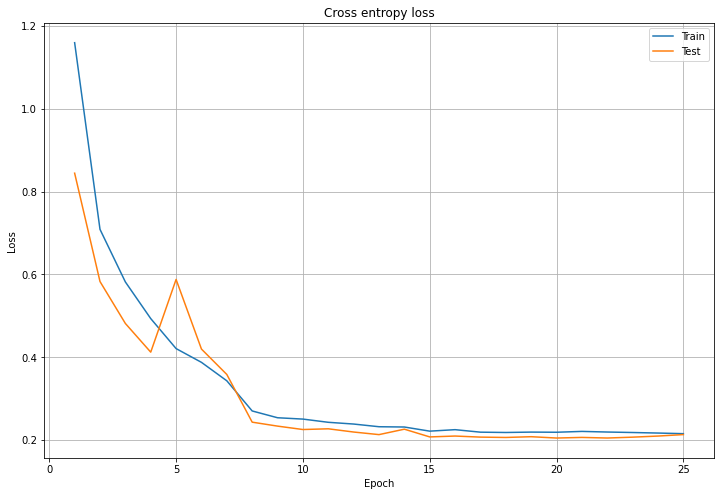

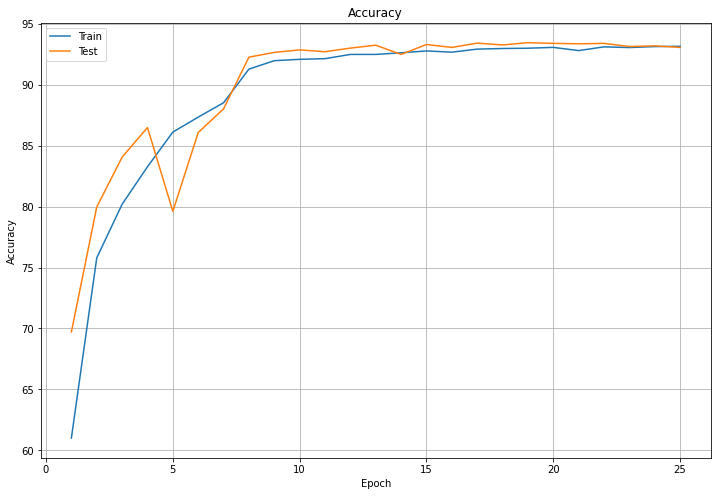

In [157]:
# Main loop
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []
epochs = []

for epoch in range(1, NUM_EPOCHS+1):
    print(f'\n\nRunning epoch {epoch} of {NUM_EPOCHS}...\n')
    epochs.append(epoch)

    #-------------------------Train-------------------------
    
    #Reset these below variables to 0 at the begining of every epoch
    correct = 0
    iterations = 0
    iter_loss = 0.0
    
    model.train()  # Put the network into training mode
    
    for i, (inputs, labels) in enumerate(train_loader):
        if USE_CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()        
            
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        iter_loss += loss.item()  # Accumulate the loss
        optimizer.zero_grad() # Clear off the gradient in (w = w - gradient)
        loss.backward()   # Backpropagation 
        optimizer.step()  # Update the weights
        
        # Record the correct predictions for training data 
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()
        iterations += 1
        
    scheduler.step()
        
    # Record the training loss
    train_loss.append(iter_loss/iterations)
    # Record the training accuracy
    train_accuracy.append((100 * correct / dataset_sizes['train']))   
     
    #-------------------------Test--------------------------
    
    correct = 0
    iterations = 0
    testing_loss = 0.0
    
    model.eval()  # Put the network into evaluation mode
    
    for i, (inputs, labels) in enumerate(test_loader):

        if USE_CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
        
        outputs = model(inputs)     
        loss = criterion(outputs, labels) # Calculate the loss
        testing_loss += loss.item()
        # Record the correct predictions for training data
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()
        
        iterations += 1

    # Record the Testing loss
    test_loss.append(testing_loss/iterations)
    # Record the Testing accuracy
    test_accuracy.append((100 * correct / dataset_sizes['val']))
   
    print(f'\nEpoch {epoch} validation results: Loss={test_loss[-1]} | Accuracy={test_accuracy[-1]}\n')


    # Plot and save
    plt.figure(figsize=(12, 8), num=1)
    plt.clf()
    plt.plot(epochs, train_loss, label='Train')
    plt.plot(epochs, test_loss, label='Test')
    plt.legend()
    plt.grid()
    plt.title('Cross entropy loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.savefig('outputs/01-loss-resnet.pdf')

    plt.figure(figsize=(12, 8), num=2)
    plt.clf()
    plt.plot(epochs, train_accuracy, label='Train')
    plt.plot(epochs, test_accuracy, label='Test')
    plt.legend()
    plt.grid()
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.savefig('outputs/02-accuracy-resnet.pdf')

# Results

In [158]:
print(f'Final train loss: {train_loss[-1]}')
print(f'Final test loss: {test_loss[-1]}')
print(f'Final train accuracy: {train_accuracy[-1]}')
print(f'Final test accuracy: {test_accuracy[-1]}')

Final train loss: 0.21561731184287183
Final test loss: 0.21340482519829976
Final train accuracy: 93.14814758300781
Final test accuracy: 93.05555725097656
